In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Science/Jax_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize as scipy_minimize

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters



#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF
import jaxtronomy.GaussianRandomField.PowerBox_jaxified as PowerBox_jax

#Utils for GRF fitting
from jaxtronomy.GaussianRandomField.GRF_fitting import get_parameters,get_lens_models,simulate_perturbed_image,simulate_smooth_image,model_loss_function
#Utils for computing axially averaged spectrum
from jaxtronomy.GaussianRandomField.GRF_fitting import Radial_profile,compute_radial_spectrum
#Utils for fitting the GRF
from jaxtronomy.GaussianRandomField.GRF_fitting import GRF_Loss_perfect_case,GRF_Loss_phase_averaging,GRF_Loss_image_fitting,Spectra_Loss_MSE,Spectra_Loss_MAE
from jaxtronomy.GaussianRandomField.GRF_fitting import fit_image_function,GRF_Loss_complete

#Utils for handling jax
from jaxtronomy.GaussianRandomField.Jax_Utils import purify_function,jax_map,gradient_descent



# Universal font size
FS = 18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Lensing setup (unknown to us)

In [2]:
#GRF true parameters
GRF_LogAmp=-10.
GRF_beta=7.
GRF_seed=1

GRF_params=[GRF_LogAmp,GRF_beta]

## Data grids

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## Models

In [4]:
#Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

#Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)
GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

#Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Source light model

In [5]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [6]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

#Combined kwargs smooth
kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

#Observation conditions and noise
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

SNR=1000
kwargs_noise={'background_rms': 0.5/SNR, 'exposure_time': np.inf}
noise=Noise(npix, npix, **kwargs_noise)

parameters=get_parameters(kwargs_data,lens_mass_model_list,source_light_model_list)

#Noiseless models
perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)

## Simulate data image

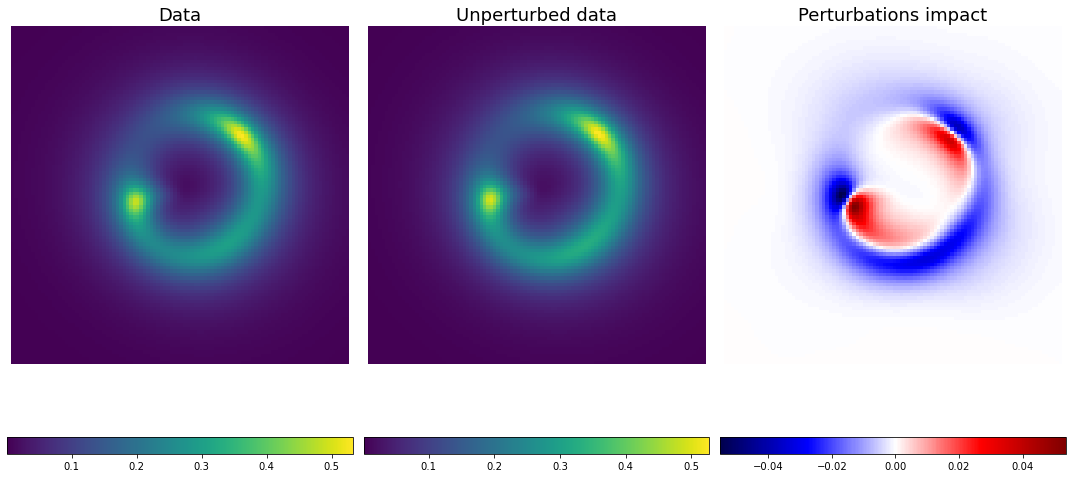

In [7]:
smooth_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)
data_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)


# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

im0=ax[0].imshow(data_image, origin='lower')
ax[0].set_title("Data", fontsize=FS)


im1=ax[1].imshow(simulate_smooth_image(kwargs_data,smooth_lens_image), origin='lower')
ax[1].set_title("Unperturbed data", fontsize=FS)


im2=ax[2].imshow(data_image-simulate_smooth_image(kwargs_data,smooth_lens_image), origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Perturbations impact", fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

# Data preparation

## Fit data to know lens-source kwargs

In [8]:
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer


def fit_data(data,lens_image,parameters,method='BFGS'):

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method=method, restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))

  return kwargs_final

In [9]:
#First guess from priors
kwargs_intermediate={'kwargs_lens': [{'theta_E': 1.5,'e1': 1e-3,'e2': 1e-3,'center_x': 1e-3,'center_y': 1e-3},{'gamma1': 1e-3, 'gamma2': 1e-3, 'ra_0': 0.0, 'dec_0': 0.0}],
                     'kwargs_source': [{'amp': 5.0,'R_sersic': 2.5,'n_sersic': 2.,'center_x': 0.,'center_y': 0.,'e1': 1e-3,'e2': 1e-3}],
                     'kwargs_lens_light': [{}]}

parameters=get_parameters(kwargs_intermediate,lens_mass_model_list,source_light_model_list)
#Get guess of true kwargs
kwargs_guess=fit_data(data_image,smooth_lens_image,parameters,method='Newton-CG')
args_guess=parameters.kwargs2args(kwargs_guess)

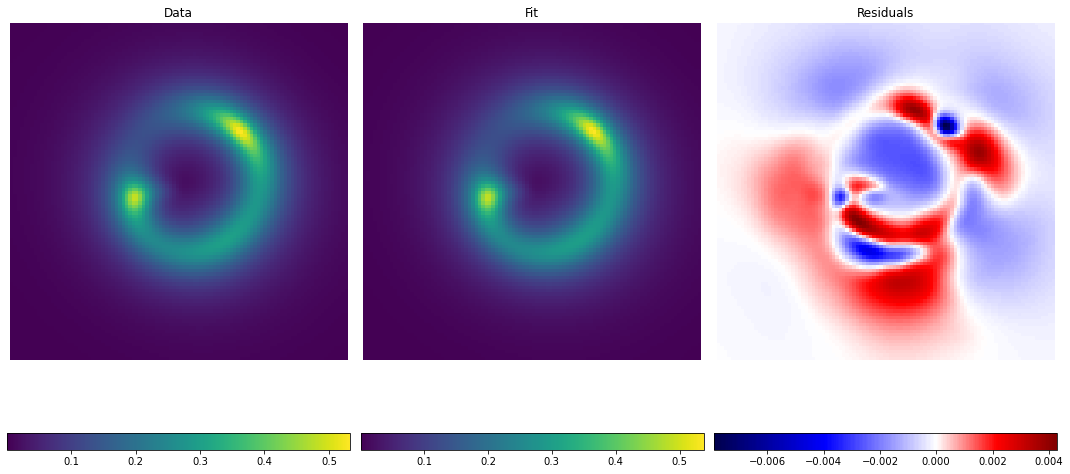

In [10]:
parameter_names=deepcopy(parameters.symbols)

parameter_names[1:5]=['$e_1^{lens}$','$e_2^{lens}$','$x_{0}^{lens}$', '$y_{0}^{lens}$']
parameter_names[-4:]=['$e_1^{source}$','$e_2^{source}$','$x_{0}^{source}$', '$y_{0}^{source}$']

fig,ax=plt.subplots(1,3,figsize=(15,7))

im_arr=[]

im=ax[0].imshow(data_image,origin='lower')
im_arr+=[im]
ax[0].set_title('Data')

fit_image=smooth_lens_image.model(**kwargs_guess)
im=ax[1].imshow(fit_image,origin='lower')
im_arr+=[im]
ax[1].set_title('Fit')

im=ax[2].imshow(data_image-fit_image,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
im_arr+=[im]
ax[2].set_title('Residuals')

for i in range(3):
    ax[i].axis('off')
    fig.colorbar(im_arr[i],ax=ax[i],orientation='horizontal')
    
fig.tight_layout()
plt.show()

## Einstein ring Mask

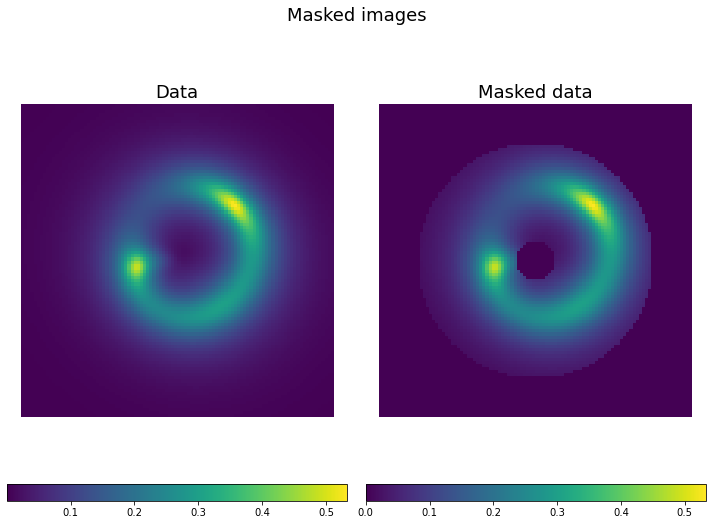

In [11]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#There is no sense to consider Fourier space frequncies referring to sizes 
#That are bigger than the thickness of the masked region
k_vector=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
#Index from which to consider frequencies
mask_spectral_cut_index=np.where(k_vector>1/(rmax-rmin))[0][0]
masked_k_vector=k_vector[mask_spectral_cut_index:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
img1 = ax1.imshow(data_image, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(data_image*mask, origin='lower')
ax2.set_title("Masked data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax,orientation='horizontal')
    ax.axis('off')
fig.suptitle('Masked images',y=1.1,fontsize=FS)
fig.tight_layout()

## Precompile utility functions

In [12]:
# Precompile the functions with all the arguments that are static for the lensing setup
# So the pure functions depend only on the argument that should be traced

#Generate GRF
def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

#Simulate images for kwargs or GRF
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_guess,perturbed_lens_image,x_coords,y_coords)
simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)

#Get axially averaged spectrum
Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

## Make the fit

In [13]:
learning_rate=5e-4
max_iter=200

model_loss_function_pure=purify_function(model_loss_function,data_image,parameters,simulate_smooth_image_pure)
model_loss_grad=jax.grad(model_loss_function_pure)

args_fit=gradient_descent(model_loss_grad,args_guess,max_iter,learning_rate)
fit_image=smooth_lens_image.model(**parameters.args2kwargs(args_fit))

## Extract spectrum

In [14]:
#Compute Target Power spectrum of data residuals 
data_resid=data_image-fit_image
data_resid_spectrum=compute_radial_spectrum_pure(data_resid)

## Fit spectrum with powerlaw to get Guess of GRF's Power slope

In [15]:
#First assumption is that power spectrum of GRF is close to power spectrum of residuals
#So fit the target power spectrum with a powerlaw to get an initial guess

def Powerlaw_spectrum(params,masked_k_vector):
  logA,Beta=params
  return np.power(10,logA)*np.power(masked_k_vector,-Beta)

def GRF_PS_loss(params,masked_k_vector,Target_spectrum):
  logA,Beta=params
  GRF_spectrum=Powerlaw_spectrum(params,masked_k_vector)
  MSE= np.power((Target_spectrum-GRF_spectrum)/Target_spectrum,2)
  return np.mean(MSE)

#Make a fit
res=scipy_minimize(GRF_PS_loss,x0=[0.,5.],args=(masked_k_vector,data_resid_spectrum))
GRF_init_guess=np.array(res.x)

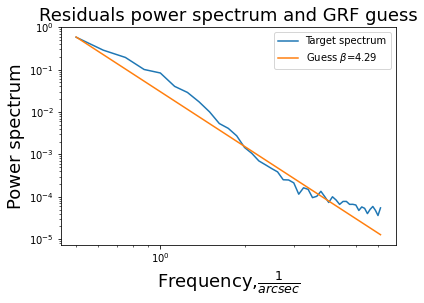

In [16]:
#Plot power spectrum and initial guess
plt.loglog(masked_k_vector,data_resid_spectrum,label='Target spectrum')
plt.loglog(masked_k_vector,Powerlaw_spectrum(GRF_init_guess,masked_k_vector),label='Guess '+r'$\beta$'+'={:.2f}'.format(GRF_init_guess[1]))
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Residuals power spectrum and GRF guess',fontsize=FS)
plt.legend()
plt.show()

# GRF fitting 1 (guess the vicinity)

In [17]:
def perturbations_constraint(GRF_params,Constraint_fraction,GRF_seed,get_jaxified_GRF_pure,simulate_perturbed_image_pure,fit_image):
    
    GRF=get_jaxified_GRF_pure(GRF_params,GRF_seed)
    simulated_image=simulate_perturbed_image_pure(GRF)
    #Residuals with the original fit
    residuals=simulated_image-fit_image
    
    #Perturbations condition
    residuals_fraction=jnp.abs(residuals).max()/fit_image.max()
    
    #residuals are no more than 10% of the unperturbed image
    return Constraint_fraction-residuals_fraction

In [18]:
#We work with MAE and only 1 seed realisation to approach the vicinity of the true GRF parameters

Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,data_resid_spectrum)

GRF_seed_guess=2
#The guessed seed should be different from the true one
assert GRF_seed!=GRF_seed_guess

GRF_Loss_image_fitting_args=(GRF_seed_guess,
                            get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
                            simulate_smooth_image_pure,model_loss_function,parameters,\
                            args_guess,learning_rate,max_iter,\
                            compute_radial_spectrum_pure,Spectra_Loss_pure)

Constraint_fraction=0.2
perturbations_constraint_pure=purify_function(perturbations_constraint,Constraint_fraction,GRF_seed_guess,get_jaxified_GRF_pure,simulate_perturbed_image_pure,fit_image)
#Maximal relation between residuals amplitude and image amplitude that can be called a perturbation

#Optimizer_constraint=NonlinearConstraint(perturbations_constraint_pure,0,Constraint_fraction,jac=jax.jit(perturbations_constraint_pure),hess=jax.jacfwd(jax.jacrev(perturbations_constraint_pure)))


GRF_Loss_pure=purify_function(GRF_Loss_image_fitting,*GRF_Loss_image_fitting_args)
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [23]:
#%timeit loss_func(GRF_params)
#%timeit grad_loss_func(GRF_params)
#%timeit hess_loss_func(GRF_params)

There are no chances to use hessian in GRF fitting if we fit the lens kwargs inside the loss function.   
Since kwargs fitting is a recursive loop with 100 cycles propagating grads through it becomes very challenging

## Optimization 1

In [27]:
Nfeval = 0
history=np.zeros((0,2))
init_guess=(-10.,GRF_init_guess[1])
bounds=((-15., -5.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    if (len(history)%10==0):
        print('{0:4d}   {1:3.6f}   {2: 3.6f}'.format(Nfeval, Xi[0], Xi[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,init_guess,jac=grad_loss_func,hess=hess_loss_func,bounds=bounds,constraints={'type': 'ineq', 'fun': perturbations_constraint_pure},\
                   method='trust-constr',callback=callbackF,options={'disp': True})

2021-09-02 00:15:25.609587: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_backward_pass__1.32302
********************************


   0   -10.000000    4.285290
  10   -9.000889    4.399017
  20   -9.092385    5.573283
  30   -9.666853    6.766873
  40   -9.732257    6.816839
  50   -9.776958    6.866930
  60   -9.832142    6.931120
  70   -9.878437    6.986074
  80   -9.892319    7.010599
  90   -9.902171    7.020024
 100   -9.905270    7.028554
 110   -9.910576    7.035026
 120   -9.912753    7.037589
 130   -9.913131    7.038123
 140   -9.916100    7.042803
 150   -9.917232    7.043825
 160   -9.917187    7.044529
 170   -9.917715    7.045361
 180   -9.917747    7.045400
 190   -9.917835    7.045575
 200   -9.917948    7.045708
 210   -9.917951    7.045719
 220   -9.918025    7.045837
 230   -9.918030    7.045842
 240   -9.918036    7.045859
 250   -9.918090    7.045936
 260   -9.918093    7.045940
 270   -9.918103    7.045960
 280   -9.918116    7.045976
 290   -9.918117    7.045978
 300   -9.918133    7.046001
 310   -9.918137    7.046009


/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


 320   -9.918139    7.046012
 330   -9.918140    7.046013
 340   -9.918140    7.046013
 350   -9.918140    7.046013
 360   -9.918140    7.046013
 370   -9.918140    7.046013
 380   -9.918140    7.046013
 390   -9.918140    7.046013
 400   -9.918140    7.046013
 410   -9.918140    7.046013
 420   -9.918140    7.046013
 430   -9.918140    7.046013
 440   -9.918140    7.046013
 450   -9.918140    7.046013
 460   -9.918140    7.046013
 470   -9.918140    7.046013
 480   -9.918140    7.046013
 490   -9.918140    7.046013
 500   -9.918140    7.046013
 510   -9.918140    7.046013
 520   -9.918140    7.046013
 530   -9.918140    7.046013
 540   -9.918140    7.046013
 550   -9.918140    7.046013
 560   -9.918140    7.046013
 570   -9.918140    7.046013
`xtol` termination condition is satisfied.
Number of iterations: 577, function evaluations: 904, CG iterations: 567, optimality: 5.67e-02, constraint violation: 0.00e+00, execution time: 3.2e+03 s.


In [28]:
#np.save(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/Fitting_1/history.npy',history)

In [19]:
history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/Fitting_1/history.npy',allow_pickle=True)
#loss_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_1/loss_history.npy',allow_pickle=True)
#grads_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_1/grads_history.npy',allow_pickle=True)
GRF_guess_1=history[-1]

# GRF fitting 2 (fine-tune the guess)

## Complete fitting setup

In [51]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,data_resid_spectrum)

Seeds_number=20
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+1+Seeds_number)

fit_image_function_pure=purify_function(fit_image_function,parameters,simulate_smooth_image_pure,args_guess,max_iter,learning_rate)

GRF_Loss_complete_args=(GRF_seeds,get_jaxified_GRF_pure,
                             simulate_perturbed_image_pure,fit_image_function_pure,\
                             compute_radial_spectrum_pure,Spectra_Loss_pure)

GRF_Loss_pure=purify_function(GRF_Loss_complete,*GRF_Loss_complete_args)

#Beta_Loss_pure=jax.jit(lambda Beta: GRF_Loss_pure([GRF_guess_1[0],Beta]))

loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(GRF_Loss_pure))

## Optimization 2 MSE

In [55]:
Nfeval = 0
history=np.zeros((0,2))
#The values obtained on the previous stage
init_guess=GRF_guess_1
bounds=((-15., -5.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    print('{0:4d}   {1:3.6f}   {2: 3.6f}'.format(Nfeval, Xi[0], Xi[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,init_guess,jac=grad_loss_func,bounds=bounds,constraints={'type': 'ineq', 'fun': perturbations_constraint_pure},\
                   method='trust-constr',callback=callbackF,options={'disp': True})

   0   -9.918140    7.046013
   1   -10.421927    6.635293
   2   -10.354728    6.677879
   3   -10.279945    6.724835
   4   -10.199131    6.776923
   5   -10.199131    6.776923


KeyboardInterrupt: 

In [56]:
#np.save(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/Fitting_2/trustc_20ph_history.npy',history)

In [54]:
#np.save(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/Fitting_2/Nelder_Mead_20phases_MAE_history.npy',history)

In [20]:
history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/Fitting_2/trustc_20ph_history.npy',allow_pickle=True)
#history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_2/trustc_nohess_history.npy',allow_pickle=True)
#history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/Fitting_2/Nelder_Mead_20phases_MAE_history.npy',allow_pickle=True)
GRF_fit=history[-1]

In [63]:
Nfeval = 0
history=history
#The values obtained on the previous stage
init_guess=GRF_fit
bounds=((-15., -5.), (1., 10.0))



def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    print('{0:4d}   {1:3.6f}   {2: 3.6f}'.format(Nfeval, Xi[0], Xi[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,init_guess,jac=grad_loss_func,bounds=bounds,constraints={'type': 'ineq', 'fun': perturbations_constraint_pure},\
                   method='trust-constr',callback=callbackF,options={'disp': True})

   0   -10.199131    6.776923
   1   -9.775328    7.055055
   2   -10.171306    6.791428
   3   -10.147999    6.804029


KeyboardInterrupt: 

In [64]:
loss_func(history[-1])

DeviceArray(0.33139193, dtype=float64)

In [65]:
loss_func(GRF_params)

DeviceArray(0.34756927, dtype=float64)

In [68]:
#np.save(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/Fitting_2/trustc_20ph_history.npy',history)

In [83]:
history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/Fitting_2/trustc_20ph_history.npy',allow_pickle=True)
GRF_fit=history[-1]

In [84]:
GRF_fit

array([-10.14799939,   6.80402949])

(0.01, 0.2)

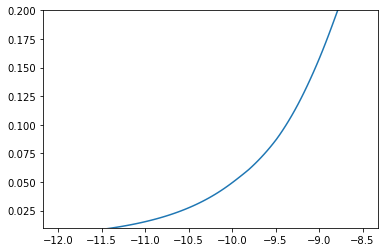

In [111]:
a_pert=np.linspace(-12,-8.5,100)
pert_lvl=np.array([-perturbations_constraint([logA,GRF_fit[1]],0,GRF_seed_guess,get_jaxified_GRF_pure,simulate_perturbed_image_pure,fit_image) for logA in a_pert])
plt.plot(a_pert,pert_lvl)
plt.ylim(0.01,0.2)

In [112]:
logA_constr=[a_pert[np.where(pert_lvl>0.01)[0][0]],a_pert[np.where(pert_lvl>0.2)[0][0]]]
logA_constr

[-11.363636363636363, -8.782828282828284]

(0.01, 0.2)

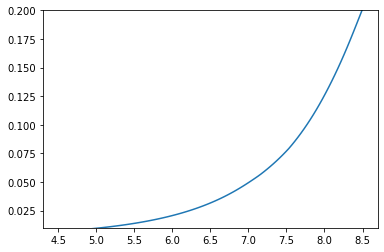

In [115]:
b_pert=np.linspace(4.5,8.5,100)
pert_lvl=np.array([-perturbations_constraint([GRF_fit[0],Beta],0,GRF_seed_guess,get_jaxified_GRF_pure,simulate_perturbed_image_pure,fit_image) for Beta in b_pert])
plt.plot(b_pert,pert_lvl)
plt.ylim(0.01,0.2)

In [116]:
Beta_constr=[b_pert[np.where(pert_lvl>0.01)[0][0]],b_pert[np.where(pert_lvl>0.2)[0][0]]]
Beta_constr

[5.065656565656566, 8.5]

In [93]:
Betas_array=np.linspace(4.5,8.5,50)
logAmps_array=np.append([-np.inf],np.linspace(-12,-8.5,49))

#Compute likelihoods for the arrays
logA_likelihood=np.zeros_like(logAmps_array)
Beta_likelihood=np.zeros_like(Betas_array)

#logA_likelihood=jax_map(jax.jit(lambda logA: jnp.exp(-loss_func([logA,GRF_fit[1]])/2)),logAmps_array)
#Beta_likelihood=jax_map(jax.jit(lambda Beta: jnp.exp(-loss_func([GRF_fit[0],Beta])/2)),logAmps_array)

In [94]:
GRF_fit

array([-10.14799939,   6.80402949])

In [95]:
for i,Beta in tqdm(enumerate(Betas_array)):
    Beta_likelihood[i]=np.exp(-loss_func([GRF_fit[0],Beta])/2)

50it [00:14,  3.57it/s]


In [96]:
for i,logA in tqdm(enumerate(logAmps_array)):
    logA_likelihood[i]=np.exp(-loss_func([logA,GRF_fit[1]])/2)

50it [00:13,  3.58it/s]


In [149]:
#np.save(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/trustc_20ph_logA_likelihood.npy',logA_likelihood)
#np.save(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/trustc_20ph_Beta_likelihood.npy',Beta_likelihood)

In [65]:
#logA_likelihood=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/trustc_20ph_logA_likelihood.npy',allow_pickle=True)
#Beta_likelihood=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Constrained_fitting/trustc_20ph_Beta_likelihood.npy',allow_pickle=True)

In [97]:
import scipy 

def gennorm(xdata,*params):
    amplitude,s,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.gennorm.pdf(x,s)


def lognormal(xdata,*params):
    amplitude,s,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.lognorm.pdf(x,s)

def fit_likelihood(xdata,ydata,distr_func='lognormal',multiplier=None,Poisson_errs=False):
    
    #It is a trick to fit distributions in very small numbers where scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
        
    if distr_func=='lognormal':
        func=lognormal
        init_guess=[1,1.,0.,1]
        
    elif distr_func=='gennorm':
        func=gennorm
        init_guess=[1,1.,1.,1]
    else:
        print('wrong distr_func')
        return None
    
        
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess)

    
    if np.isin(distr_func,['lognormal','gennorm']):
        amplitude,s,loc,scale=popt
        return amplitude,s,loc/multiplier,scale/multiplier

In [24]:
'''logAmps_array_wide=np.append([-np.inf],np.linspace(-14,GRF_fit[0]+3,49))
logA_likelihood_wide=np.zeros_like(logAmps_array_wide)

for i,logA in tqdm(enumerate(logAmps_array_wide)):
    logA_likelihood_wide[i]=np.exp(-loss_func([logA,GRF_fit[1]])/2)'''

50it [00:18,  2.71it/s]


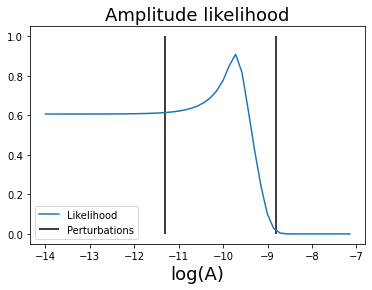

In [62]:
'''plt.plot(logAmps_array_wide,logA_likelihood_wide,label='Likelihood')
plt.vlines(-11.3,0,1,colors='black',label='Perturbations')
plt.vlines(-8.8,0,1,colors='black')
plt.xlabel('log(A)',fontsize=FS)
plt.title('Amplitude likelihood',fontsize=FS)
plt.legend(loc='lower left')'''

In [120]:
logAmps_array[np.where(logAmps_array>logA_constr[1])[0][0]]

-8.71875

In [127]:
np.where(Betas_array>Beta_constr[1])

(array([], dtype=int64),)

In [130]:
pert_logAmps_array=logAmps_array[np.where(logAmps_array>logA_constr[0])[0][0]:np.where(logAmps_array>logA_constr[1])[0][0]]
pert_logA_likelihood=logA_likelihood[np.where(logAmps_array>logA_constr[0])[0][0]:np.where(logAmps_array>logA_constr[1])[0][0]]

pert_Beta_array=Betas_array[np.where(Betas_array>Beta_constr[0])[0][0]:]
pert_Beta_likelihood=Beta_likelihood[np.where(Betas_array>Beta_constr[0])[0][0]:]

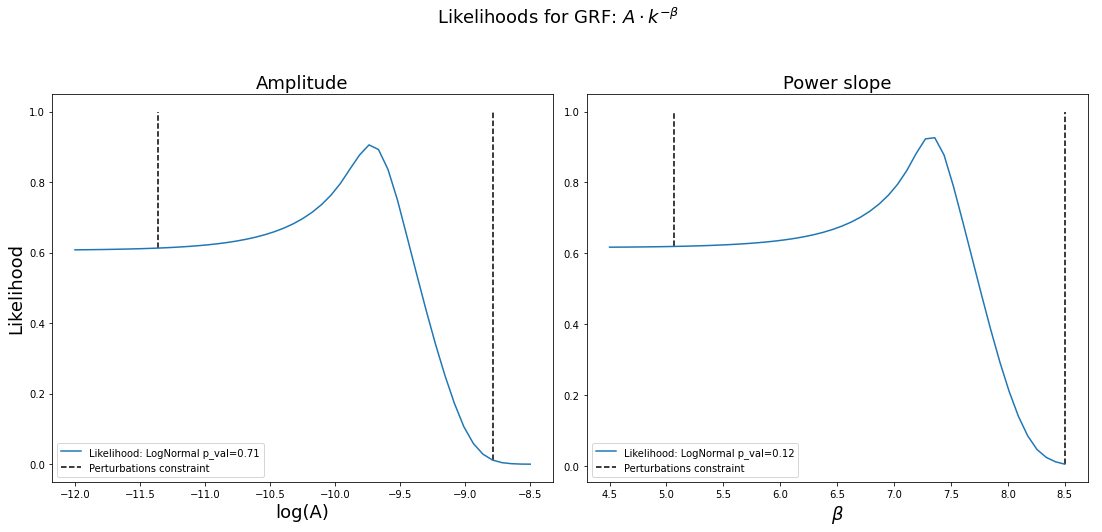

In [144]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

popt=fit_likelihood(np.power(10,pert_logAmps_array),pert_logA_likelihood,distr_func='lognormal',Poisson_errs=True)
y_fit=lognormal(np.power(10,pert_logAmps_array),*popt)

ax[0].plot(logAmps_array,logA_likelihood,label='Likelihood: LogNormal p_val={:.2f}'.format(scipy.stats.ks_2samp(pert_logA_likelihood,y_fit)[1]))
ax[0].vlines(logA_constr[0],pert_logA_likelihood[0],1,colors='black',label='Perturbations constraint',linestyles='dashed')
ax[0].vlines(logA_constr[1],pert_logA_likelihood[-1],1,colors='black',linestyles='dashed')

#ax[0].hlines
#ax[0].set_xscale('log')
ax[0].set_xlabel('log(A)',fontsize=FS)
ax[0].set_title('Amplitude',fontsize=FS)
ax[0].legend(loc='lower left')

popt=fit_likelihood(pert_Beta_array,pert_Beta_likelihood,distr_func='lognormal',Poisson_errs=False)
y_fit=lognormal(pert_Beta_array,*popt)

ax[1].plot(Betas_array,Beta_likelihood,label='Likelihood: LogNormal p_val={:.2f}'.format(scipy.stats.ks_2samp(pert_Beta_likelihood,y_fit)[1]))
ax[1].vlines(Beta_constr[0],pert_Beta_likelihood[0],1,colors='black',label='Perturbations constraint',linestyles='dashed')
ax[1].vlines(Beta_constr[1],pert_Beta_likelihood[-1],1,colors='black',linestyles='dashed')
ax[1].set_xlabel(r'$\beta$',fontsize=FS)
ax[1].set_title('Power slope',fontsize=FS)
ax[1].legend(loc='lower left')

fig.suptitle('Likelihoods for GRF: '+r'$A \cdot k^{-\beta}$',fontsize=FS,y=1.05)
fig.tight_layout()  

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
#plt.xlabel('Number of phase realisations used',labelpad=20,fontsize=FS)
plt.ylabel('Likelihood',fontsize=FS)
plt.show()


In [139]:
def get_cdf(likelihood):
    cdf=np.cumsum(likelihood)
    normalised_cdf=cdf/cdf[-1]
    
    return normalised_cdf

def get_conf_intervals(xdata,likelihood,center='median',percentage_covered=68.):
    
    cdf=get_cdf(likelihood)
    indent=np.minimum(0.5,percentage_covered/200.)
    
    if center=='median':
        value_index=np.where(cdf>=0.5)[0][0]
    elif center=='max':
        value_index=np.argmax(likelihood)
    else:
        print('wrong center')
        return None
        
    value=xdata[value_index]
    cdf_value=cdf[value_index]
    upper_bound=xdata[np.where(cdf<=cdf_value+indent)[0][-1]]
    lower_bound=xdata[np.where(cdf>=cdf_value-indent)[0][0]]
    
    upper_add=upper_bound-value
    lower_add=value-lower_bound
    return lower_add,value,upper_add

In [140]:
get_conf_intervals(pert_logAmps_array,pert_logA_likelihood,center='median',percentage_covered=68.)

(0.7291666666666661, -10.177083333333334, 0.5833333333333339)

In [141]:
get_conf_intervals(pert_Beta_array,pert_Beta_likelihood,center='median',percentage_covered=68.)

(0.9795918367346941, 6.622448979591836, 0.8163265306122449)

True values $log(A)=-10$ ,  $\beta=7$


Gaussian likelihood predicts $log(A)=-10.18 ^{+0.58} _{-0.73}$ ,  $\beta=6.62^{+0.82} _{-0.98}$ 

# Validation

In [64]:
unperturbed_data_image=simulate_smooth_image(kwargs_data,smooth_lens_image)
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,compute_radial_spectrum_pure(unperturbed_data_image))

Seeds_number=7
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+1+Seeds_number)
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_data,perturbed_lens_image,x_coords,y_coords)
    
GRF_Loss_args=(GRF_seeds,unperturbed_data_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)

In [66]:
A_array=np.linspace(-8.,-6.,100)
Beta_array=np.linspace(0.,5.5,100)

In [74]:
def compute_func_on_grid(GRF_Amps_array,GRF_Betas_array,func,output_size):
    res=np.zeros((len(GRF_Amps_array),len(GRF_Betas_array),output_size))

    for i in tqdm(range(len(GRF_Amps_array))):
        for j in range(len(GRF_Betas_array)):
            res[i,j]=func([GRF_Amps_array[i],GRF_Betas_array[j]])
            
    return res
#likelihood_grid=compute_func_on_grid(A_array,Beta_array,lambda GRF_params: np.exp(-GRF_Loss_pure(GRF_params)/2),output_size=1)[:,:,0]

In [72]:
#np.save(Folder+'Data/Phase_averaging/MSE/likelihood_14ph.npy',likelihood_grid)
#np.save(Folder+'Data/Phase_averaging/MSE/A_array.npy',A_array)
#np.save(Folder+'Data/Phase_averaging/MSE/Beta_array.npy',Beta_array)


In [73]:
#likelihood_grid=np.load(Folder+'Data/Phase_averaging/MSE/likelihood_14ph.npy',allow_pickle=True)
#A_array=np.load(Folder+'Data/Phase_averaging/MSE/A_array.npy',allow_pickle=True)
#Beta_array=np.load(Folder+'Data/Phase_averaging/MSE/Beta_array.npy',allow_pickle=True)

In [135]:
A_array=np.linspace(-8.,-6.,100)
Beta_array=np.linspace(0.5,3.5,100)

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)


num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

In [136]:
def merge_arrays_by_index(index_arr_1,index_arr_2,values_arr_1,values_arr_2):
    complete_index=np.append(index_arr_1,index_arr_2)
    sort_index=np.argsort(complete_index)
    
    complete_values=np.append(values_arr_1,values_arr_2,axis=0)
    
    return complete_index[sort_index],complete_values[sort_index]

In [137]:
lin_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_loss_seeds_grid.npy',allow_pickle=True)
lin_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_seeds_numbers.npy',allow_pickle=True)

In [138]:
log_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/loss_seeds_grid.npy',allow_pickle=True)
log_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/seeds_numbers.npy',allow_pickle=True)

In [139]:
Seeds_numbers,loss_seeds_grid=merge_arrays_by_index(lin_Seeds_numbers,log_Seeds_numbers,lin_loss_seeds_grid,log_loss_seeds_grid)
Seeds_numbers=Seeds_numbers[1:]
loss_seeds_grid=loss_seeds_grid[1:]

In [ ]:
#Adjust history to heatmaps
def reindex_history(history):
  i_min=np.argmin(np.abs(np.nanmin(history[:,0])-A_array))
  j_min=np.argmin(np.abs(np.nanmin(history[:,1])-Beta_array))

  history_x_labels=j_min+(history[:,1]-np.nanmin(history[:,1]))/(Beta_array[1]-Beta_array[0])
  history_y_labels=i_min+(history[:,0]-np.nanmin(history[:,0]))/(A_array[1]-A_array[0])
  return history_x_labels,history_y_labels

In [140]:
fit1_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_1/history.npy',allow_pickle=True)
fit2_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_2/Nelder_Mead_7phases_history.npy',allow_pickle=True)

fit1_history_x,fit1_history_y=reindex_history(fit1_history)
fit2_history_x,fit2_history_y=reindex_history(fit2_history)

In [146]:
xticklabels

array([0.5 , 0.83, 1.17, 1.5 , 1.83, 2.17, 2.5 , 2.83, 3.17, 3.5 ])

(-8.0, -6.0)

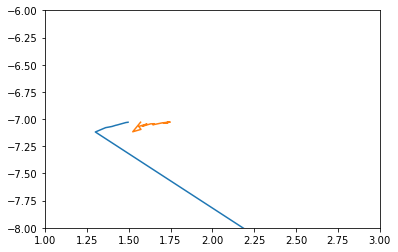

In [168]:
plt.plot(fit1_history[:,1],fit1_history[:,0],label='MAE fitting')
plt.plot(fit2_history[:,1],fit2_history[:,0],label='MSE fitting')
plt.xlim(1,3)
plt.ylim(-8,-6)


In [163]:
fit1_history[:,1]

array([3.980653, 5.103964, 1.301097, 1.362528, 1.384602, 1.400857,
       1.422623, 1.432909, 1.446102, 1.46329 , 1.48472 , 1.493448,
       1.494433, 1.495747, 1.49643 , 1.496439])

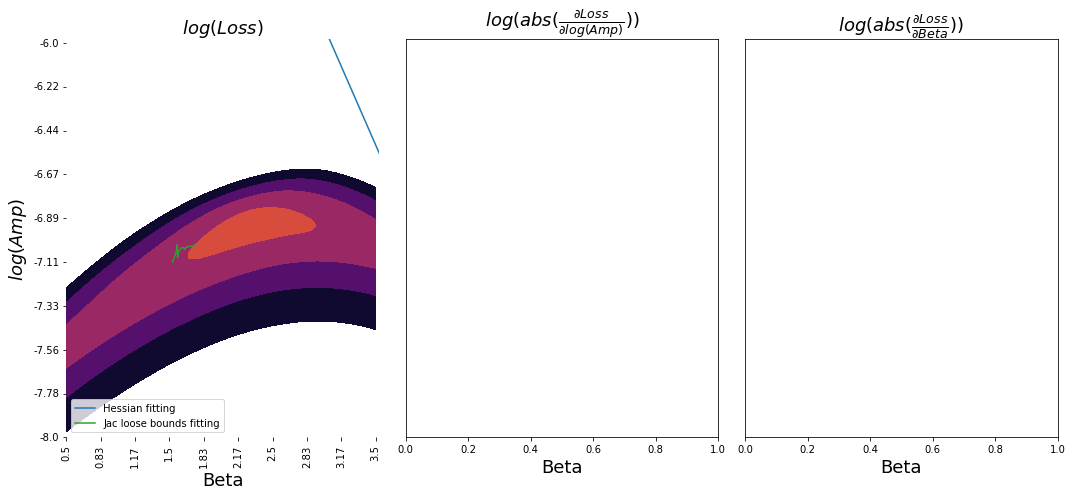

In [158]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

#Loss
im=sns.heatmap(ax=ax[0],data=np.exp(-loss_seeds_grid[5]/2),alpha=0,cbar=False)
ct=ax[0].contourf(likelihood, levels=np.linspace(0.7,1,7), cmap='inferno')
set_labels(im)
#Fitting
sns.lineplot(ax=ax[0],x=fit1_history_x,y=fit1_history_y,label='Hessian fitting',color='C0')
#ax[0].lines[0].set_linestyle((0, (1, 4)))
sns.lineplot(ax=ax[0],x=fit2_history_x,y=fit2_history_y,label='Jac loose bounds fitting',color='C2')
#ax[0].lines[1].set_linestyle((0, (3, 5, 1, 5)))
ax[0].legend(loc='lower left')

#Grad Amp


#Grad Beta


ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()
  

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

In [116]:
#Adjust history to heatmaps
def reindex_history(history):
  i_min=np.argmin(np.abs(np.nanmin(history[:,0])-A_array))
  j_min=np.argmin(np.abs(np.nanmin(history[:,1])-Beta_array))

  history_x_labels=j_min+(history[:,1]-np.nanmin(history[:,1]))/(Beta_array[1]-Beta_array[0])
  history_y_labels=i_min+(history[:,0]-np.nanmin(history[:,0]))/(A_array[1]-A_array[0])
  return history_x_labels,history_y_labels

In [117]:
fit1_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_1/history.npy',allow_pickle=True)
fit2_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_2/Nelder_Mead_7phases_history.npy',allow_pickle=True)

In [118]:
fit1_history_x,fit1_history_y=reindex_history(fit1_history)
fit2_history_x,fit2_history_y=reindex_history(fit2_history)

In [128]:
fit1_history_x

array([71.232008, 91.451606, 23.      , 24.105758, 24.50309 , 24.79568 ,
       25.187468, 25.372616, 25.61009 , 25.919474, 26.305214, 26.462318,
       26.480048, 26.5037  , 26.515994, 26.516156])

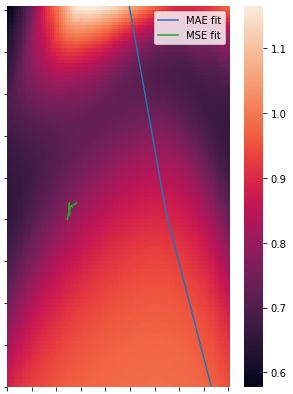

In [126]:
plt.figure(figsize=(5,7))

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

#Loss
im=sns.heatmap(data=-np.log(likelihood_grid)*2,xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)
#Fitting
sns.lineplot(x=fit1_history_x,y=fit1_history_y,label='MAE fit',color='C0')
sns.lineplot(x=fit2_history_x,y=fit2_history_y,label='MSE fit',color='C2')
ax[0].legend(loc='lower left')

plt.gca().invert_yaxis()

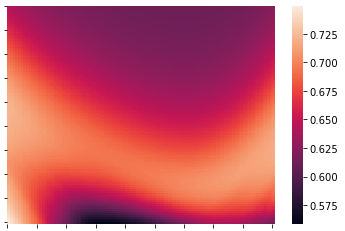

In [129]:
im=sns.heatmap(data=likelihood_grid,xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

In [151]:
    plt.figure(figsize=(5,7))
    loss_grid=loss_seeds_grid[loss_grid_indices[i]]
    likelihood=np.exp(-loss_grid/2)
    min_i,min_j=np.where(loss_grid==loss_grid.min())
    im=sns.heatmap(data=likelihood,xticklabels=x_labels,yticklabels=yticklabels,alpha=0,cbar=False)
    
    ct=plt.contourf(likelihood, levels=np.linspace(0.7,1,7), cmap='inferno')
    
    
    sns.scatterplot(x=[50],y=[50],label='Ground truth')
    sns.scatterplot(x=[min_j.item()],y=[min_i.item()],label='Fit value',color='black')
    
    plt.legend()
    
    plt.xlabel(r'$\beta$',fontsize=FS)
    plt.ylabel('log(A)',fontsize=FS)
    
    plt.gca().invert_yaxis()
    set_labels(im)
    plt.title('MSE %d phases likelihood'%(Seeds_numbers[loss_grid_indices[i]]),fontsize=FS)
    plt.colorbar()

NameError: name 'loss_grid_indices' is not defined

<Figure size 360x504 with 0 Axes>